In [208]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import NearestNeighbors
from sklearn.ensemble import RandomForestClassifier
from statsmodels.tsa.arima.model import ARIMA
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report, mean_squared_error, r2_score
import matplotlib.pyplot as plt


# Early Career Opportunity

## Data Prep

In [209]:
# Load all data files from 1990 to 2024 into a single DataFrame
matches = pd.read_csv(r"C:\Users\shivg\OneDrive\Desktop\GitHub\Tennis_ATP\data\all_matches.csv", low_memory=False)
matches['tourney_date'] = pd.to_datetime(matches['tourney_date'], format='%Y%m%d', errors='coerce')
matches.to_csv()

,Unnamed: 0,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_seed,...,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,winner_rank,winner_rank_points,loser_rank,loser_rank_points
0,0,1990-339,Adelaide,Hard,32,A,1990-01-01,1,101843,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,25.0,591.0,282.0,70.0
1,1,1990-339,Adelaide,Hard,32,A,1990-01-01,2,100714,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,146.0,157.0,127.0,182.0
2,2,1990-339,Adelaide,Hard,32,A,1990-01-01,3,101529,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,113.0,215.0,71.0,290.0
3,3,1990-339,Adelaide,Hard,32,A,1990-01-01,4,100628,7.0,...,NaN,NaN,NaN,NaN,NaN,NaN,68.0,297.0,80.0,271.0
4,4,1990-339,Adelaide,Hard,32,A,1990-01-01,5,101404,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,34.0,496.0,100.0,224.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110392,110392,2024-M-DC-2024-WG2-PO-URU-MDA-01,Davis Cup WG2 PO: URU vs MDA,Clay,4,D,2024-02-03,5,212051,NaN,...,30.0,17.0,7.0,6.0,8.0,14.0,1109.0,8.0,740.0,34.0
110393,110393,2024-M-DC-2024-WG2-PO-VIE-RSA-01,Davis Cup WG2 PO: VIE vs RSA,Hard,4,D,2024-02-02,1,122533,NaN,...,41.0,25.0,6.0,9.0,1.0,4.0,554.0,67.0,748.0,32.0
110394,110394,2024-M-DC-2024-WG2-PO-VIE-RSA-01,Davis Cup WG2 PO: VIE vs RSA,Hard,4,D,2024-02-02,2,144748,NaN,...,51.0,25.0,7.0,11.0,5.0,12.0,416.0,109.0,NaN,NaN
110395,110395,2024-M-DC-2024-WG2-PO-VIE-RSA-01,Davis Cup WG2 PO: VIE vs RSA,Hard,4,D,2024-02-02,4,122533,NaN,...,51.0,32.0,17.0,14.0,5.0,9.0,554.0,67.0,416.0,109.0


## Feature Engineering

### Defining an Upset/Opportunity

In [241]:
# Defining the 'is_upset' Feature

# Make sure columns are numeric
matches['winner_rank'] = pd.to_numeric(matches['winner_rank'])
matches['loser_rank'] = pd.to_numeric(matches['loser_rank'])

# Set rank difference threshold to define an upset (A larger value is a more shocking upset [Bigger Oppertunity] )
rank_threshold = 100

# Create Feature

matches['is_upset'] = (matches['winner_rank'] > matches['loser_rank']) &\
                      (matches['winner_rank'] - matches['loser_rank'].abs() > rank_threshold)

In [242]:
# Total Number of Upsets from 1990 to 2024
matches['is_upset'].value_counts()

False    104400
True       5997
Name: is_upset, dtype: int64

### How many upsets in the first 'n' matches

In [243]:
# Calculate player's age at the time of the match
matches['winner_age'] = pd.to_numeric(matches['winner_age'], errors='coerce')
matches['loser_age'] = pd.to_numeric(matches['loser_age'], errors='coerce')

# Sort matches by player and tourney_date for cumulative
matches = matches.sort_values(['winner_id', 'tourney_date'])

# Early-career performance: Number of upsets in the first n matches
n_matches = 100

In [244]:
# Function to calculate early-career upset frequency
def early_career_upsets(match_history):
    match_history['early_upsets'] = match_history['is_upset'].cumsum().shift(fill_value=0)
    match_history['early_upsets'] = match_history['early_upsets'].where(match_history['match_num'] <= n_matches, other=None)
    return match_history

matches = matches.groupby('winner_id').apply(early_career_upsets)

### Tournament Level and Surface Encoding

In [245]:
# Handle missing values in tourney_level and surface
matches['tourney_level'] = matches['tourney_level'].fillna('Unknown')
matches['surface'] = matches['surface'].fillna('Unknown')

In [246]:
# One-hot encoding for surface and tourney_level
tourney_level_encoded = pd.get_dummies(matches['tourney_level'], prefix='tourney_level', drop_first=True)
surface_encoded = pd.get_dummies(matches['surface'], prefix='surface', drop_first=True)


In [247]:
matches = pd.concat([matches, tourney_level_encoded, surface_encoded], axis=1)

# Dynamically update feature_columns to include all generated columns
feature_columns = (
        ['early_upsets', 'lifetime_highest_rank', 'scaled_tournaments_won'] +
        list(tourney_level_encoded.columns) +
        list(surface_encoded.columns)
)

# Check if all feature columns exist in the dataframe
print("Available columns in data:", matches.columns)
print("Selected feature columns:", feature_columns)

Available columns in data: Index(['Unnamed: 0', 'tourney_id', 'tourney_name', 'surface', 'draw_size',
       'tourney_level', 'tourney_date', 'match_num', 'winner_id',
       'winner_seed', 'winner_entry', 'winner_name', 'winner_hand',
       'winner_ht', 'winner_ioc', 'winner_age', 'loser_id', 'loser_seed',
       'loser_entry', 'loser_name', 'loser_hand', 'loser_ht', 'loser_ioc',
       'loser_age', 'score', 'best_of', 'round', 'minutes', 'w_ace', 'w_df',
       'w_svpt', 'w_1stIn', 'w_1stWon', 'w_2ndWon', 'w_SvGms', 'w_bpSaved',
       'w_bpFaced', 'l_ace', 'l_df', 'l_svpt', 'l_1stIn', 'l_1stWon',
       'l_2ndWon', 'l_SvGms', 'l_bpSaved', 'l_bpFaced', 'winner_rank',
       'winner_rank_points', 'loser_rank', 'loser_rank_points', 'is_upset',
       'early_upsets', 'tourney_level_D', 'tourney_level_F', 'tourney_level_G',
       'tourney_level_M', 'surface_Clay', 'surface_Grass', 'surface_Hard',
       'surface_Unknown', 'lifetime_highest_rank', 'scaled_tournaments_won',
       'succe


## The Outcome - Measuring Success

**Lifetime Highest Rank**:

A player’s career-best rank should inversely contribute to success (e.g., rank #1 is the most successful). We can transform this using a scaling factor: `100 - lifetime_highest_rank`, ensuring higher ranks contribute more to success.

**Number of Early Career Upsets**:

Use the cumulative number of early career upsets, with more upsets contributing positively to success.

**Tournaments Won (Scaled by Difficulty)**:

Scale the number of tournaments won by their draw size:
- **Small Draw (32)**: Weight = 1.0
- **Medium Draw (64)**: Weight = 1.5
- **Large Draw (128)**: Weight = 2.0

**Overall Success Score**:

Combine these factors into a weighted formula:

$\text{Success Score} = w_1 \cdot (100 - \text{Lifetime Highest Rank}) + w_2 \cdot (\text{Early Upsets}) + w_3 \cdot (\text{Scaled Tournaments Won})$

Weights (`w1`, `w2`, `w3`) can be adjusted based on the relative importance of each factor.




In [248]:
def calculate_scaled_tournaments_won(match_history):
    # Scale based on draw size (example weights: 32=1, 64=1.5, 128=2)
    draw_size_weights = {32: 1, 64: 1.5, 128: 2}
    match_history['scaled_tournaments_won'] = match_history['draw_size'].map(draw_size_weights).fillna(1) * match_history['tourney_level'].notnull()
    return match_history['scaled_tournaments_won'].sum()

def calculate_success(row, highest_rank_column, early_upsets_column, w1=0.2, w2=0.7):
    # Calculate success score
    lifetime_highest_rank = row[highest_rank_column]
    early_career_upsets = row[early_upsets_column]

    success_score = (
            w1 * (100 - lifetime_highest_rank) +
            w2 * early_career_upsets
    )
    return success_score


In [249]:
# Group by player to compute lifetime stats
matches['lifetime_highest_rank'] = matches.groupby('winner_id')['winner_rank'].transform('min')

# Compute the scaled tournaments won per player
matches['scaled_tournaments_won'] = matches.groupby('winner_id').apply(calculate_scaled_tournaments_won)

# Apply the success function
matches['success_score'] = matches.apply(
    calculate_success,
    axis=1,
    args=('lifetime_highest_rank', 'early_upsets')
)

In [250]:
success_threshold = matches['success_score'].quantile(0.80)  # Top 20% of players
matches['high_success'] = matches['success_score'] >= success_threshold

## Modeling

In [251]:
# Update feature columns to include encoded variables
feature_columns = (
        ['early_upsets', 'lifetime_highest_rank', 'scaled_tournaments_won'] +
        list(tourney_level_encoded.columns) +
        list(surface_encoded.columns)
)

In [252]:
X = matches[feature_columns].dropna()
y_classification = matches.loc[X.index, 'high_success']  # Binary classification target
y_regression = matches.loc[X.index, 'success_score']     # Continuous regression target

In [265]:
matches.to_csv(r"C:\Users\shivg\OneDrive\Desktop\GitHub\Tennis_ATP\data\matches_with_success.csv")

In [254]:
X_train, X_temp, y_class_train, y_class_temp = train_test_split(
    X, y_classification, test_size=0.2, random_state=42
)
X_val, X_test, y_class_val, y_class_test = train_test_split(
    X_temp, y_class_temp, test_size=0.5, random_state=42
)


In [255]:
# Regression target split
y_reg_train, y_reg_temp = train_test_split(y_regression, test_size=0.2, random_state=42)
y_reg_val, y_reg_test = train_test_split(y_reg_temp, test_size=0.5, random_state=42)


In [256]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [257]:
# Display the prepared
print("Training Features:", X_train_scaled.shape)
print("Validation Features:", X_val_scaled.shape)
print("Test Features:", X_test_scaled.shape)

Training Features: (129, 19)
Validation Features: (16, 19)
Test Features: (17, 19)


In [258]:
# Initialize models
log_reg = LogisticRegression(random_state=42)
rf_clf = RandomForestClassifier(random_state=42, n_estimators=100)

# Train Logistic Regression
log_reg.fit(X_train_scaled, y_class_train)
y_pred_log_reg = log_reg.predict(X_val_scaled)

# Train Random Forest
rf_clf.fit(X_train_scaled, y_class_train)
y_pred_rf = rf_clf.predict(X_val_scaled)

In [259]:
# Evaluate models
print("Logistic Regression Metrics:")
print("Accuracy:", accuracy_score(y_class_val, y_pred_log_reg))
print("F1 Score:", f1_score(y_class_val, y_pred_log_reg))
print("ROC AUC:", roc_auc_score(y_class_val, log_reg.predict_proba(X_val_scaled)[:, 1]))

print("\nRandom Forest Metrics:")
print("Accuracy:", accuracy_score(y_class_val, y_pred_rf))
print("F1 Score:", f1_score(y_class_val, y_pred_rf))
print("ROC AUC:", roc_auc_score(y_class_val, rf_clf.predict_proba(X_val_scaled)[:, 1]))

Logistic Regression Metrics:
Accuracy: 0.9375
F1 Score: 0.8
ROC AUC: 0.9743589743589745

Random Forest Metrics:
Accuracy: 0.875
F1 Score: 0.5
ROC AUC: 1.0


In [260]:
# Initialize models
lin_reg = LinearRegression()
rf_reg = RandomForestRegressor(random_state=42, n_estimators=100)

# Train Linear Regression
lin_reg.fit(X_train_scaled, y_reg_train)
y_pred_lin_reg = lin_reg.predict(X_val_scaled)

# Train Random Forest Regressor
rf_reg.fit(X_train_scaled, y_reg_train)
y_pred_rf_reg = rf_reg.predict(X_val_scaled)

# Evaluate models
print("Linear Regression Metrics:")
print("RMSE:", mean_squared_error(y_reg_val, y_pred_lin_reg, squared=False))
print("R2 Score:", r2_score(y_reg_val, y_pred_lin_reg))

print("\nRandom Forest Regression Metrics:")
print("RMSE:", mean_squared_error(y_reg_val, y_pred_rf_reg, squared=False))
print("R2 Score:", r2_score(y_reg_val, y_pred_rf_reg))

Linear Regression Metrics:
RMSE: 6.33632983447227e-14
R2 Score: 1.0

Random Forest Regression Metrics:
RMSE: 1.4044396569450706
R2 Score: 0.9917334705883895


In [261]:
# Step 1: Ensure matches is a DataFrame
if not isinstance(matches, pd.DataFrame):
    raise TypeError("Expected 'matches' to be a Pandas DataFrame. Please check the earlier steps.")

# Ensure 'early_upsets' exists and is numeric
if 'early_upsets' not in matches.columns:
    raise KeyError("The column 'early_upsets' is missing from the dataset. Ensure it is created during feature engineering.")

# Fill missing values if necessary
matches['early_upsets'] = matches['early_upsets'].fillna(0)

# Step 2: Create binary column for early upsets
matches['early_upset_binary'] = (matches['early_upsets'] > 0).astype(int)

# Confirm the binary column was created
print(matches[['early_upsets', 'early_upset_binary']].head())


# Ensure 'early_upsets' exists and is numeric
if 'early_upsets' not in matches.columns:
    raise KeyError("The column 'early_upsets' is missing from the dataset. Ensure it is created during feature engineering.")

# Fill missing values if necessary
matches['early_upsets'] = matches['early_upsets'].fillna(0)

# Step 1: Propensity Score Model
# Predict the likelihood of "early_upsets" > 0
matches['early_upset_binary'] = (matches['early_upsets'] > 0).astype(int)

# Confirm the binary column was created
print(matches[['early_upsets', 'early_upset_binary']].head())

# Train propensity score model
prop_model = LogisticRegression(random_state=42)
prop_model.fit(X_train_scaled, matches.loc[X_train.index, 'early_upset_binary'])

# Step 2: Compute propensity scores
X_train_ps = prop_model.predict_proba(X_train_scaled)[:, 1]

# Separate treated and control groups
treated = X_train[matches.loc[X_train.index, 'early_upset_binary'] == 1]
control = X_train[matches.loc[X_train.index, 'early_upset_binary'] == 0]
treated_scores = X_train_ps[matches.loc[X_train.index, 'early_upset_binary'] == 1]
control_scores = X_train_ps[matches.loc[X_train.index, 'early_upset_binary'] == 0]

# Step 3: Nearest Neighbors Matching
nn = NearestNeighbors(n_neighbors=1)
nn.fit(control_scores.reshape(-1, 1))

# Find the closest neighbors for treated samples
matches_nn = nn.kneighbors(treated_scores.reshape(-1, 1), return_distance=False).flatten()

# Ensure the matches are within bounds
if len(matches_nn) > len(control):
    matches_nn = matches_nn[:len(control)]

matched_control = control.iloc[matches_nn]

# Step 4: Compare Outcomes
treated_outcomes = y_reg_train[matches.loc[X_train.index, 'early_upset_binary'] == 1]
control_outcomes = y_reg_train[matched_control.index]

# Calculate Causal Effect
causal_effect = treated_outcomes.mean() - control_outcomes.mean()
print("Estimated Causal Effect of Early Upsets on Success Score:", causal_effect)

      early_upsets  early_upset_binary
4426           0.0                   0
4712           1.0                   1
4736           2.0                   1
5373           3.0                   1
5410           4.0                   1
      early_upsets  early_upset_binary
4426           0.0                   0
4712           1.0                   1
4736           2.0                   1
5373           3.0                   1
5410           4.0                   1
Estimated Causal Effect of Early Upsets on Success Score: -10.071134020618551


In [262]:
# Example: ARIMA for player rank trajectory
player_id = matches['winner_id'].iloc[0]  # Pick an example player
player_data = matches[matches['winner_id'] == player_id].sort_values('tourney_date')
rank_series = player_data['lifetime_highest_rank'].dropna()

# Train ARIMA model
arima_model = ARIMA(rank_series, order=(1, 1, 0))  # Adjust ARIMA parameters as needed
arima_results = arima_model.fit()

# Forecast future ranks
forecast = arima_results.forecast(steps=5)
print(f"Rank Forecast for Player {player_id}:", forecast)

Rank Forecast for Player 100284: 42    33.0
43    33.0
44    33.0
45    33.0
46    33.0
Name: predicted_mean, dtype: float64


C:\Users\shivg\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\shivg\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\shivg\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\shivg\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\shivg\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be give

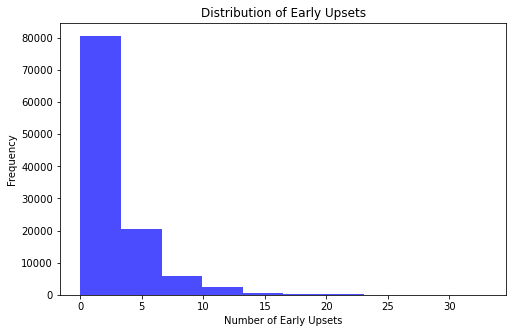

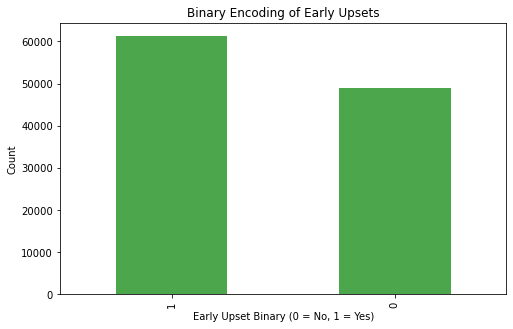

In [263]:
# Histogram for early_upsets
plt.figure(figsize=(8, 5))
plt.hist(matches['early_upsets'], bins=10, alpha=0.7, color='blue')
plt.title('Distribution of Early Upsets')
plt.xlabel('Number of Early Upsets')
plt.ylabel('Frequency')
plt.show()

# Bar chart for binary encoding
binary_counts = matches['early_upset_binary'].value_counts()
plt.figure(figsize=(8, 5))
binary_counts.plot(kind='bar', alpha=0.7, color='green')
plt.title('Binary Encoding of Early Upsets')
plt.xlabel('Early Upset Binary (0 = No, 1 = Yes)')
plt.ylabel('Count')
plt.show()

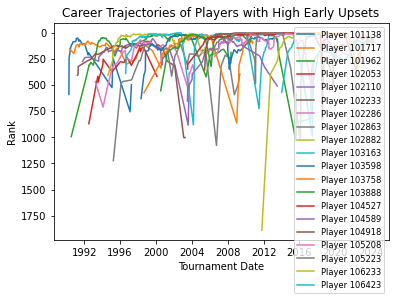

In [264]:
# 4. Career Trajectories of Individuals with High Early Upsets
# Assuming matches DataFrame contains a 'career_rank' column over time per player
high_upset_threshold = 15
high_upset_players = matches[matches['early_upsets'] > high_upset_threshold]['winner_id'].unique()

for player_id in high_upset_players:
    player_data = matches[matches['winner_id'] == player_id].sort_values('tourney_date')
    plt.plot(player_data['tourney_date'], player_data['winner_rank'], label=f'Player {player_id}')

plt.title('Career Trajectories of Players with High Early Upsets')
plt.xlabel('Tournament Date')
plt.ylabel('Rank')
plt.gca().invert_yaxis()  # Lower rank is better
plt.legend(loc='upper right', fontsize='small')
plt.show()
